# DoW detection integrating entropy maths with Bi-lstm

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Concatenate, Input
from keras.models import Model
import time

2024-02-28 23:43:53.160723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 23:43:53.160832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 23:43:53.307373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load dataset
df = pd.read_csv('/kaggle/input/network-traffic-for-dos-detection/dataset.csv')

# Print columns of the DataFrame
print("Columns after loading dataset:")
print(df.columns)

Columns after loading dataset:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')


In [6]:
def calculate_entropy(feature_values):
    # Convert float64 data to integer by rounding
    feature_values = np.round(feature_values).astype(int)
    
    # Count occurrences of each unique value in the feature
    value_counts = np.bincount(feature_values)
    
    # Calculate probability of each unique value
    probabilities = value_counts / len(feature_values)
    
    # Calculate entropy
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Adding a small value to avoid log(0)
    
    return entropy

In [7]:
# Function to prepare dataset and calculate entropy
def prepare_dataset(df):
    # Select relevant features
    selected_features = ['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest', 
                         'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcorecountbucket', 'vmmemorybucket']
    
    # Normalize selected features if necessary
    scaler = MinMaxScaler()
    df[selected_features] = scaler.fit_transform(df[selected_features])
    
    # Calculate entropy for each data instance
    for feature in selected_features:
        df[feature + '_entropy'] = df.groupby('IP')[feature].transform(lambda x: calculate_entropy(x.values))
    
    # Print columns after adding entropy columns
    print("Columns after adding entropy columns:")
    print(df.columns)
    
    return df


In [8]:
# Function to prepare data for model training
def prepare_data_for_model(df):
    # Convert categorical variables to numerical labels if necessary
    label_encoder = LabelEncoder()
    df['vmcategory'] = label_encoder.fit_transform(df['vmcategory'])
    
    # Select features and target
    selected_features = ['RTT_entropy', 'InvocationDelay_entropy', 'ResponseDelay_entropy', 'FunctionDuration_entropy', 
                         'ActiveFunctionsAtRequest_entropy', 'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 
                         'avgcpu_entropy', 'p95maxcpu_entropy', 'vmcorecountbucket_entropy', 'vmmemorybucket_entropy']
    X = df[selected_features].values
    y = df['bot'].values
    
    # Reshape data for LSTM input
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y

In [9]:
# Print columns of the DataFrame
print("Columns after loading dataset:")
print(df.columns)

Columns after loading dataset:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')


In [10]:
# Function to build Bi-LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
# Prepare dataset and calculate entropy
df = prepare_dataset(df)

Columns after adding entropy columns:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket', 'RTT_entropy',
       'InvocationDelay_entropy', 'ResponseDelay_entropy',
       'FunctionDuration_entropy', 'ActiveFunctionsAtRequest_entropy',
       'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 'avgcpu_entropy',
       'p95maxcpu_entropy', 'vmcorecountbucket_entropy',
       'vmmemorybucket_entropy'],
      dtype='object')


In [12]:
# Prepare data for model training
X, y = prepare_data_for_model(df)

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
# Build Bi-LSTM model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))


In [15]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
3508/3508 [==============================] - 69s 18ms/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0044 - val_accuracy: 0.9994
Epoch 2/10
3508/3508 [==============================] - 56s 16ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 3/10
3508/3508 [==============================] - 57s 16ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 3.9857e-04 - val_accuracy: 0.9999
Epoch 4/10
3508/3508 [==============================] - 51s 15ms/step - loss: 4.9318e-04 - accuracy: 0.9999 - val_loss: 9.7214e-06 - val_accuracy: 1.0000
Epoch 5/10
3508/3508 [==============================] - 49s 14ms/step - loss: 4.7057e-06 - accuracy: 1.0000 - val_loss: 1.6889e-06 - val_accuracy: 1.0000
Epoch 6/10
3508/3508 [==============================] - 49s 14ms/step - loss: 8.1279e-07 - accuracy: 1.0000 - val_loss: 3.1007e-07 - val_accuracy: 1.0000
Epoch 7/10
3508/3508 [==============================] - 48s 14ms/step - loss: 1.5254e-07 - accur

In [16]:
print(X_test)

[[[0.15374218]
  [0.15374218]
  [0.98247409]
  ...
  [0.47600055]
  [0.99603836]
  [0.99603836]]

 [[0.17028942]
  [0.17028942]
  [0.97022384]
  ...
  [0.51970279]
  [0.99702505]
  [0.99702505]]

 [[0.135528  ]
  [0.135528  ]
  [0.97464571]
  ...
  [0.50325833]
  [0.99679163]
  [0.99679163]]

 ...

 [[0.15374218]
  [0.15374218]
  [0.96261471]
  ...
  [0.45953223]
  [0.99619538]
  [0.99619538]]

 [[0.18312207]
  [0.18312207]
  [0.96896729]
  ...
  [0.48120324]
  [0.9964625 ]
  [0.9964625 ]]

 [[0.12010676]
  [0.12010676]
  [0.97895964]
  ...
  [0.50988914]
  [0.99679163]
  [0.99679163]]]


In [17]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate model on testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on testing set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Flatten y_pred_binary
y_pred_binary_flat = y_pred_binary.flatten()

# Calculate metrics for testing set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Detect potential DoS attacks
# Assuming '1' represents a potential DoS attack in the 'bot' column
dos_indices = np.where(y_pred_binary == 1)[0]
dos_instances = df.iloc[dos_indices]

print("Potential DoS Attack Instances:")
print(dos_instances)


1170/1170 [==============================] - 5s 4ms/step - loss: 5.6346e-09 - accuracy: 1.0000
Validation Loss: 5.6345594856566095e-09
Validation Accuracy: 1.0
1170/1170 [==============================] - 5s 5ms/step - loss: 5.6137e-09 - accuracy: 1.0000
Test Loss: 5.613685960526027e-09
Test Accuracy: 1.0
1170/1170 [==============================] - 6s 4ms/step
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0
Confusion Matrix:
[[11185     0]
 [    0 26233]]
Potential DoS Attack Instances:
          Id               IP   bot  FunctionId functionTrigger  \
0          0    38.57.146.249  True          12    notification   
1          1   55.220.132.116  True          12    notification   
2          2    141.232.38.48  True          12    notification   
4          4   223.113.21.186  True          12    notification   
5          5   223.113.21.186  True          12    notification   
...      ...              ...   ...         ...             ...   
37413  3741

In [18]:
dos_instances.head(50)

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,...,InvocationDelay_entropy,ResponseDelay_entropy,FunctionDuration_entropy,ActiveFunctionsAtRequest_entropy,ActiveFunctionsAtResponse_entropy,maxcpu_entropy,avgcpu_entropy,p95maxcpu_entropy,vmcorecountbucket_entropy,vmmemorybucket_entropy
0,0,38.57.146.249,True,12,notification,2022-01-02T03:31:34.498Z,73,0.755164,0.764222,0.284672,...,0.134662,0.977670,0.150265,0.996213,0.751270,0.343382,0.654316,0.502097,0.996638,0.996638
1,1,55.220.132.116,True,12,notification,2022-01-02T03:54:53.136Z,73,0.755164,0.764222,0.284672,...,0.171245,0.980654,0.128017,0.995705,0.768901,0.377763,0.640836,0.495365,0.996268,0.996268
2,2,141.232.38.48,True,12,notification,2022-01-02T03:38:31.950Z,73,0.755164,0.764222,0.284672,...,0.137261,0.976695,0.133040,0.988800,0.777365,0.321536,0.619942,0.566510,0.997832,0.997832
4,4,223.113.21.186,True,12,notification,2022-01-02T03:52:54.326Z,73,0.755164,0.764222,0.284672,...,0.122292,0.976354,0.175946,0.999950,0.702052,0.361241,0.703501,0.396773,0.994816,0.994816
5,5,223.113.21.186,True,12,notification,2022-01-02T03:53:51.412Z,73,0.755164,0.764222,0.284672,...,0.122292,0.976354,0.175946,0.999950,0.702052,0.361241,0.703501,0.396773,0.994816,0.994816
6,6,243.138.37.32,True,12,notification,2022-01-02T03:24:03.665Z,73,0.755164,0.764222,0.284672,...,0.172411,0.974263,0.142298,0.999874,0.759431,0.374347,0.633910,0.473605,0.996156,0.996156
7,7,243.138.37.32,True,12,notification,2022-01-02T03:24:48.516Z,73,0.755164,0.764222,0.284672,...,0.172411,0.974263,0.142298,0.999874,0.759431,0.374347,0.633910,0.473605,0.996156,0.996156
8,8,94.35.80.22,True,12,notification,2022-01-02T03:30:07.778Z,73,0.755164,0.764222,0.284672,...,0.189505,0.966992,0.136628,0.999339,0.761091,0.369761,0.606973,0.473094,0.996229,0.996229
9,9,112.21.188.21,True,12,notification,2022-01-02T03:14:21.516Z,73,0.755164,0.764222,0.284672,...,0.175946,0.967608,0.157518,0.999264,0.769193,0.379257,0.609840,0.475565,0.996234,0.996234
11,11,24.205.101.151,True,12,notification,2022-01-02T03:10:55.543Z,73,0.755164,0.764222,0.284672,...,0.150359,0.978342,0.129489,0.989415,0.783777,0.341496,0.617510,0.558115,0.997570,0.997570


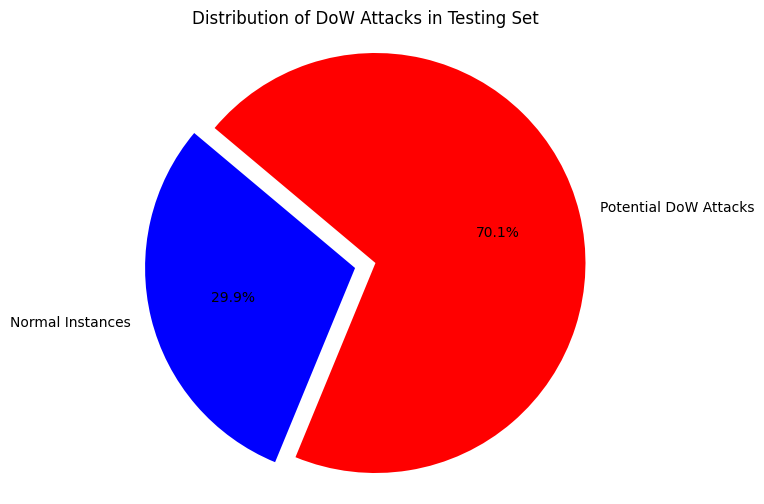

In [19]:
import matplotlib.pyplot as plt

# Calculate the percentage of DoS attacks based on the testing set
total_instances_test = len(y_test)
dos_percentage_test = np.sum(y_test) / total_instances_test * 100
normal_percentage_test = 100 - dos_percentage_test

# Pie chart for the distribution of DoS attacks in the testing set
labels = ['Normal Instances', 'Potential DoW Attacks']
sizes = [normal_percentage_test, dos_percentage_test]
colors = ['blue', 'red']  # Using a contrasting color for DoS attacks
explode = (0, 0.1)  # Explode the 2nd slice (i.e., 'Potential DoS Attacks')

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of DoW Attacks in Testing Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


Number of potential DoW attacks: 18480
Sample of potential DoW attacks:
            Id              IP   bot  FunctionId functionTrigger  \
113471  113471  223.113.21.186  True          23             sql   
113472  113472  223.113.21.186  True          23             sql   
113473  113473  223.113.21.186  True          23             sql   
113474  113474  223.113.21.186  True          23             sql   
113475  113475  223.113.21.186  True          23             sql   

                       timestamp  SubmitTime       RTT  InvocationDelay  \
113471  2022-01-02T03:53:06.751Z          76  0.669502         0.671971   
113472  2022-01-02T03:53:15.085Z          76  0.669502         0.671971   
113473  2022-01-02T03:53:20.163Z          76  0.669502         0.671971   
113474  2022-01-02T03:53:26.700Z          76  0.669502         0.671971   
113475  2022-01-02T03:53:33.788Z          76  0.669502         0.671971   

        ResponseDelay  ...  InvocationDelay_entropy  ResponseDelay_e

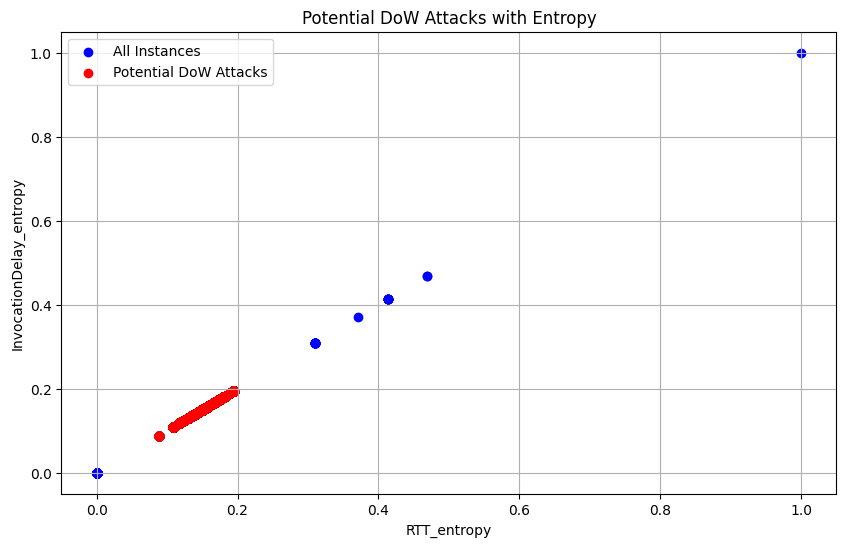

In [20]:
# Get the indices of the testing set
test_indices = np.arange(len(X_train), len(X_train) + len(X_test))

# Filter df to include only samples from the testing set
df_test = df.iloc[test_indices]

# Define entropy threshold
entropy_threshold = -1.442695e-10  # Example threshold value

# Detect potential DoS attacks based on model predictions and entropy values
potential_dos_mask = (
    (y_pred_binary_flat == 1) &
    (df_test['RTT_entropy'] > entropy_threshold) &
    (df_test['InvocationDelay_entropy'] > entropy_threshold) &
    (df_test['ResponseDelay_entropy'] > entropy_threshold) &
    (df_test['FunctionDuration_entropy'] > entropy_threshold) &
    (df_test['ActiveFunctionsAtRequest_entropy'] > entropy_threshold) &
    (df_test['ActiveFunctionsAtResponse_entropy'] > entropy_threshold) &
    (df_test['maxcpu_entropy'] > entropy_threshold) &
    (df_test['avgcpu_entropy'] > entropy_threshold) &
    (df_test['p95maxcpu_entropy'] > entropy_threshold) &
    (df_test['vmcorecountbucket_entropy'] > entropy_threshold) &
    (df_test['vmmemorybucket_entropy'] > entropy_threshold)
)

# Print the number of potential DoS attacks identified
print("Number of potential DoW attacks:", np.sum(potential_dos_mask))

# Inspect a sample of the DataFrame to ensure the filtering is correct
print("Sample of potential DoW attacks:")
print(df_test[potential_dos_mask].head())

# Choose two entropy features for visualization
entropy_feature1 = 'RTT_entropy'
entropy_feature2 = 'InvocationDelay_entropy'

# Plot potential DoS attacks with corresponding entropy values
plt.figure(figsize=(10, 6))
plt.scatter(df_test[entropy_feature1], df_test[entropy_feature2], c='blue', label='All Instances')
plt.scatter(df_test[potential_dos_mask][entropy_feature1], df_test[potential_dos_mask][entropy_feature2], c='red', label='Potential DoW Attacks')
plt.xlabel(entropy_feature1)
plt.ylabel(entropy_feature2)
plt.title('Potential DoW Attacks with Entropy')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Function to calculate recall, specificity, and accuracy
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return accuracy, recall, specificity

# Function to plot sampling overhead (Figure 10)
def plot_sampling_overhead(function_requests, sampling_overhead_percentage):
    plt.figure(figsize=(8, 6))
    plt.plot(function_requests, sampling_overhead_percentage, marker='o')
    plt.xlabel('Function Requests')
    plt.ylabel('Sampling Overhead (%)')
    plt.title('Sampling Overhead of Gringotts')
    plt.grid(True)
    plt.show()

# Function to plot detection delay (Figure 11)
def plot_detection_delay(techniques, detection_delay_seconds):
    plt.figure(figsize=(8, 6))
    plt.bar(techniques, detection_delay_seconds)
    plt.xlabel('Detection Techniques')
    plt.ylabel('Detection Delay (Seconds)')
    plt.title('Comparison of Detection Delay')
    plt.grid(True)
    plt.show()

# Function to plot influence of detection threshold on metrics (Figure 12)
def plot_threshold_influence(threshold_values, recall_values, specificity_values, accuracy_values):
    plt.figure(figsize=(8, 6))
    plt.plot(threshold_values, recall_values, label='Recall')
    plt.plot(threshold_values, specificity_values, label='Specificity')
    plt.plot(threshold_values, accuracy_values, label='Accuracy')
    plt.xlabel('Threshold Value')
    plt.ylabel('Metric Value')
    plt.title('Influence of Detection Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot influence of Hc factor on metrics (Figure 13)
def plot_hc_influence(hc_values, recall_values, specificity_values, accuracy_values):
    plt.figure(figsize=(8, 6))
    plt.plot(hc_values, recall_values, label='Recall')
    plt.plot(hc_values, specificity_values, label='Specificity')
    plt.plot(hc_values, accuracy_values, label='Accuracy')
    plt.xlabel('Hc Factor')
    plt.ylabel('Metric Value')
    plt.title('Influence of Hc Factor on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot end-to-end evaluation results (Figure 14)
def plot_end_to_end_evaluation_results(models, accuracy_percentages, time_seconds):
    plt.figure(figsize=(8, 6))
    for model, accuracy_percentage in zip(models, accuracy_percentages):
        plt.plot(time_seconds, accuracy_percentage, label=model)
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Accuracy (%)')
    plt.title('End-to-End Evaluation Results of Different Models')
    plt.legend()
    plt.grid(True)
    plt.show()



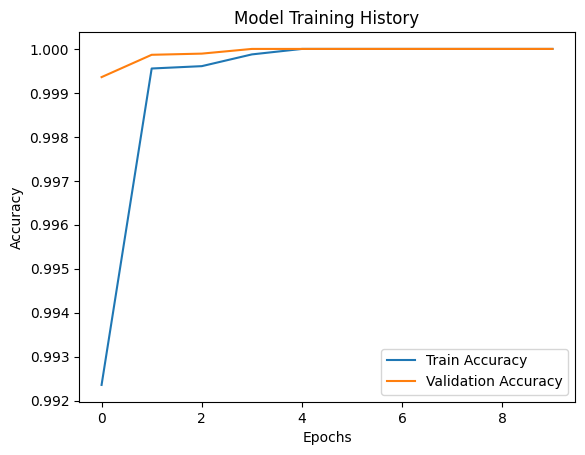

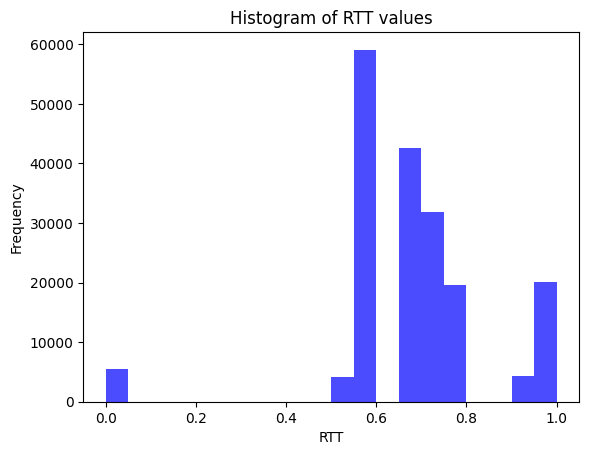

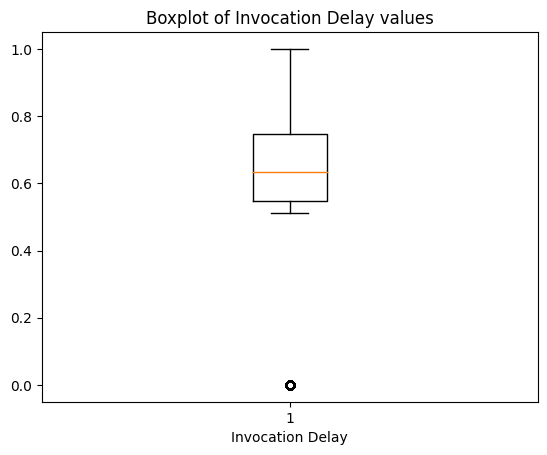

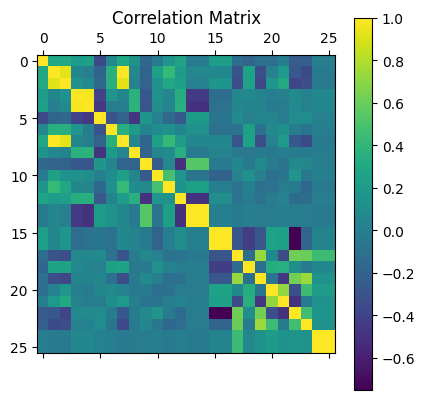

Mean of Response Delay: 0.370069363894699
Standard Deviation of Response Delay: 0.3312763999655215


In [22]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training History')
plt.legend()
plt.show()

# Plotting other graphs and calculating additional metrics

# Plotting Histogram of RTT values
plt.hist(df['RTT'], bins=20, color='blue', alpha=0.7)
plt.xlabel('RTT')
plt.ylabel('Frequency')
plt.title('Histogram of RTT values')
plt.show()

# Plotting Boxplot of Invocation Delay values
plt.boxplot(df['InvocationDelay'])
plt.xlabel('Invocation Delay')
plt.title('Boxplot of Invocation Delay values')
plt.show()

# Remove non-numeric and categorical columns
numeric_df = df.select_dtypes(include=['number'])

# Plotting Correlation Matrix
correlation_matrix = numeric_df.corr()
plt.matshow(correlation_matrix, cmap='viridis')
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

# Calculating and printing mean and standard deviation of Response Delay
response_delay_mean = df['ResponseDelay'].mean()
response_delay_std = df['ResponseDelay'].std()
print("Mean of Response Delay:", response_delay_mean)
print("Standard Deviation of Response Delay:", response_delay_std)


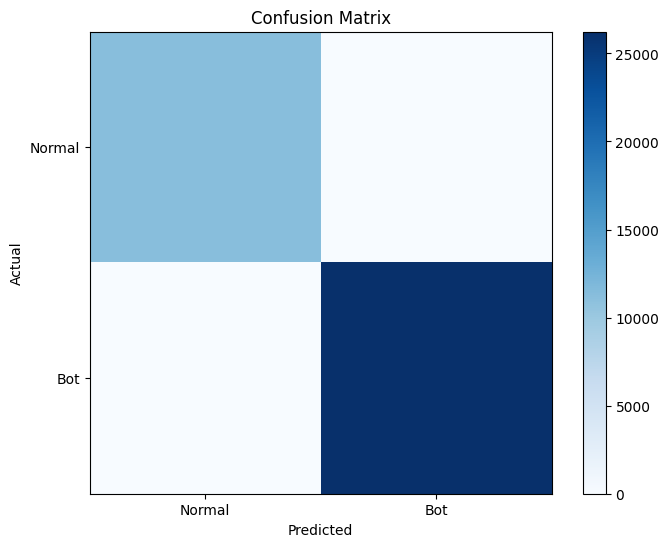

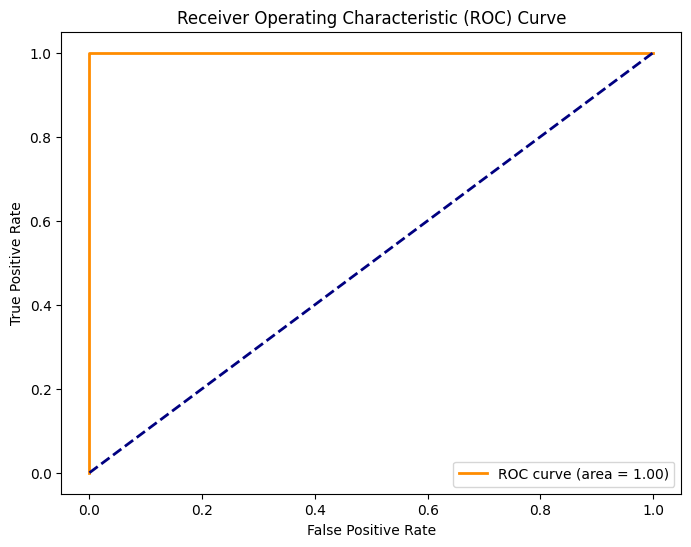

In [23]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Normal', 'Bot'])
plt.yticks([0, 1], ['Normal', 'Bot'])
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

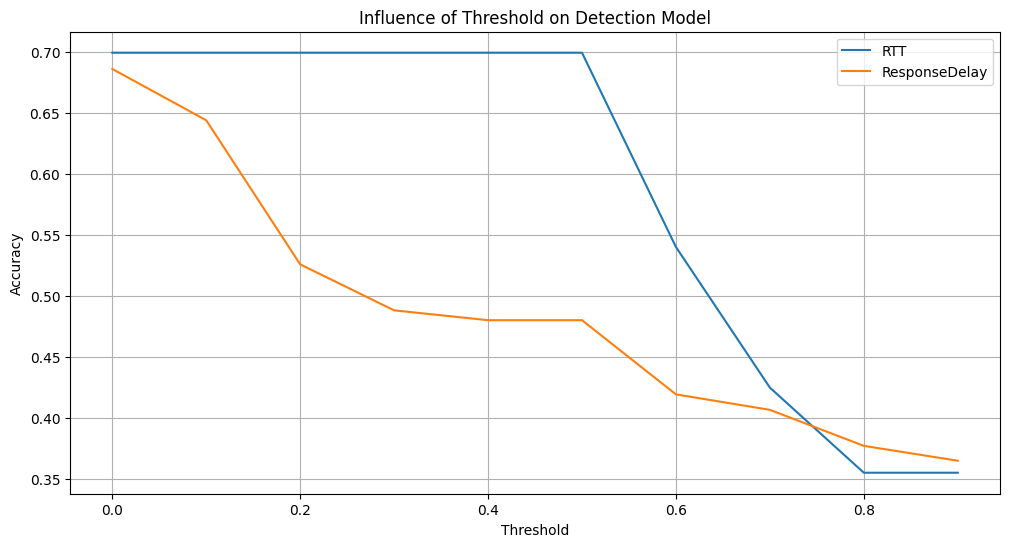

In [24]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt

def influence_of_threshold(df, target_column, feature_columns, threshold_range):
    threshold_results = {}
    
    for feature_column in feature_columns:
        feature_data = df[[feature_column]]
        X_train, X_test, y_train, y_test = train_test_split(feature_data, df[target_column], test_size=0.2, random_state=42)
        
        accuracy_scores = []
        for threshold in threshold_range:
            y_pred = (X_test > threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_scores.append(accuracy)
        
        threshold_results[feature_column] = accuracy_scores
    
    return threshold_results

# Example usage
# Assuming df is your dataset, 'bot' is the target column, and 'RTT' and 'ResponseDelay' are feature columns
threshold_range = np.arange(0, 1, 0.1)  # Example threshold range from 0 to 1 with step 0.1
threshold_results = influence_of_threshold(df, 'bot', ['RTT', 'ResponseDelay'], threshold_range)

# Plot the influence of threshold for each feature column
plt.figure(figsize=(12, 6))
for feature_column, scores in threshold_results.items():
    plt.plot(threshold_range, scores, label=feature_column)

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Influence of Threshold on Detection Model')
plt.legend()
plt.grid(True)
plt.show()


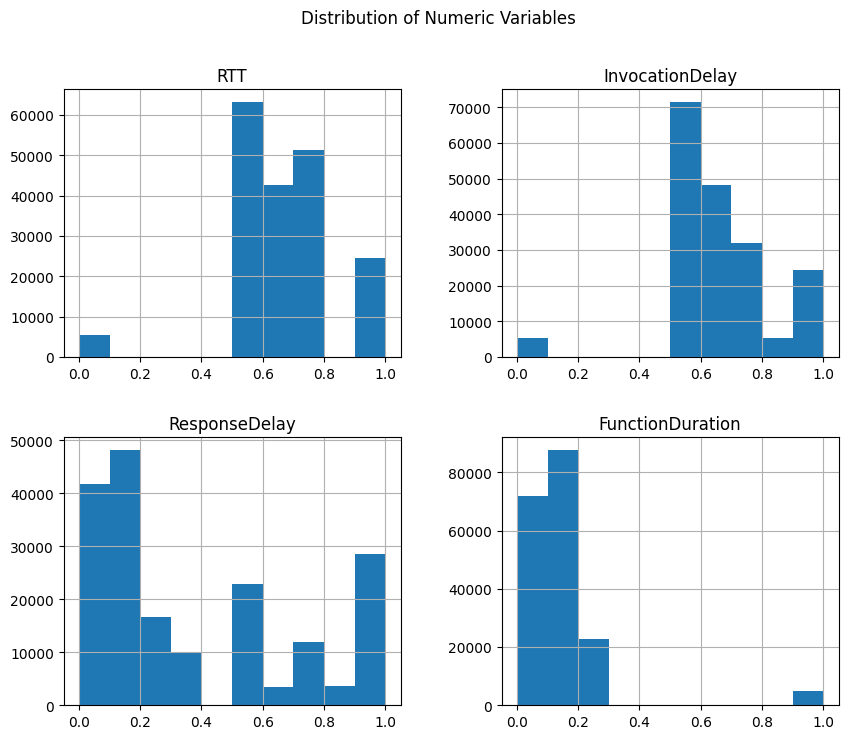

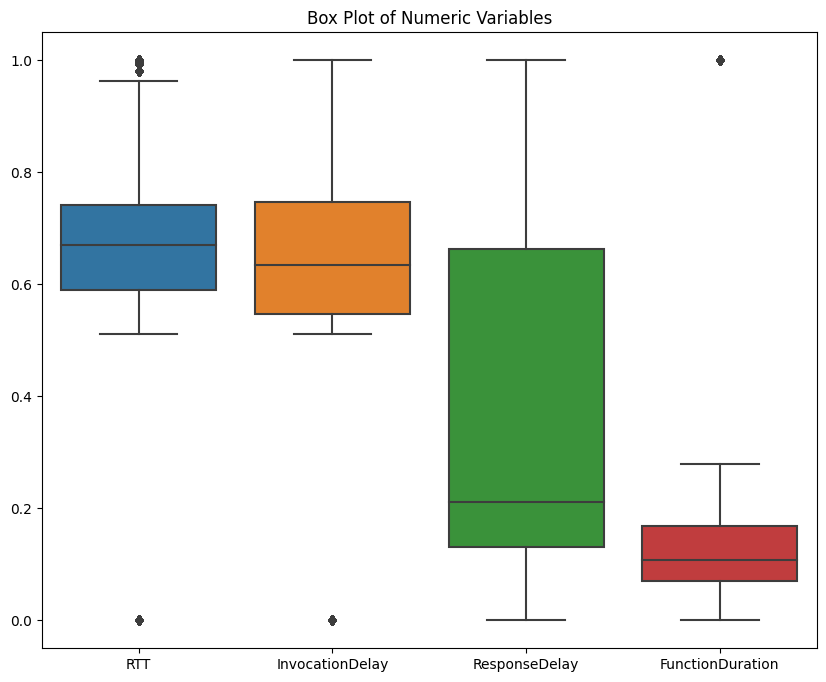

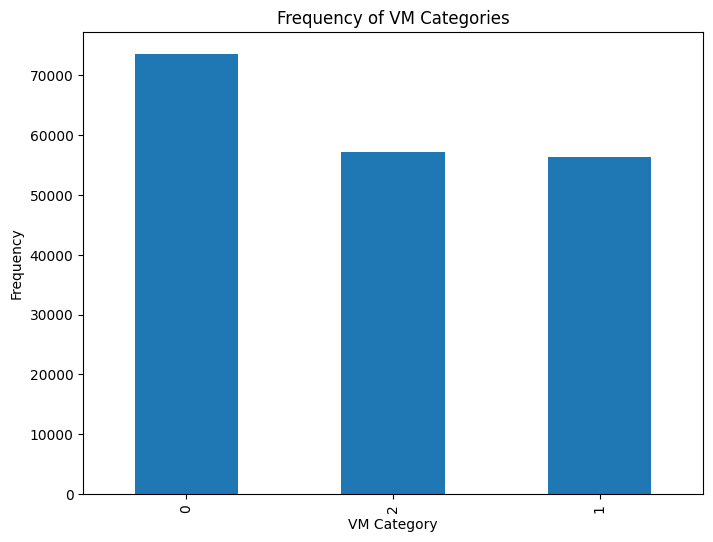

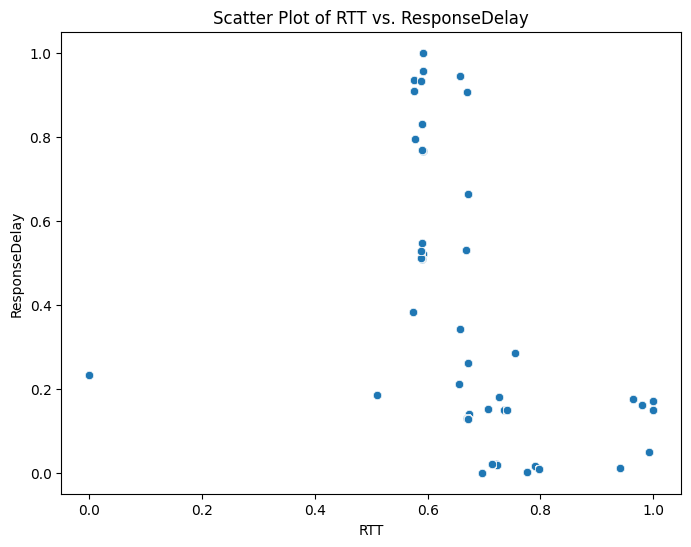

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

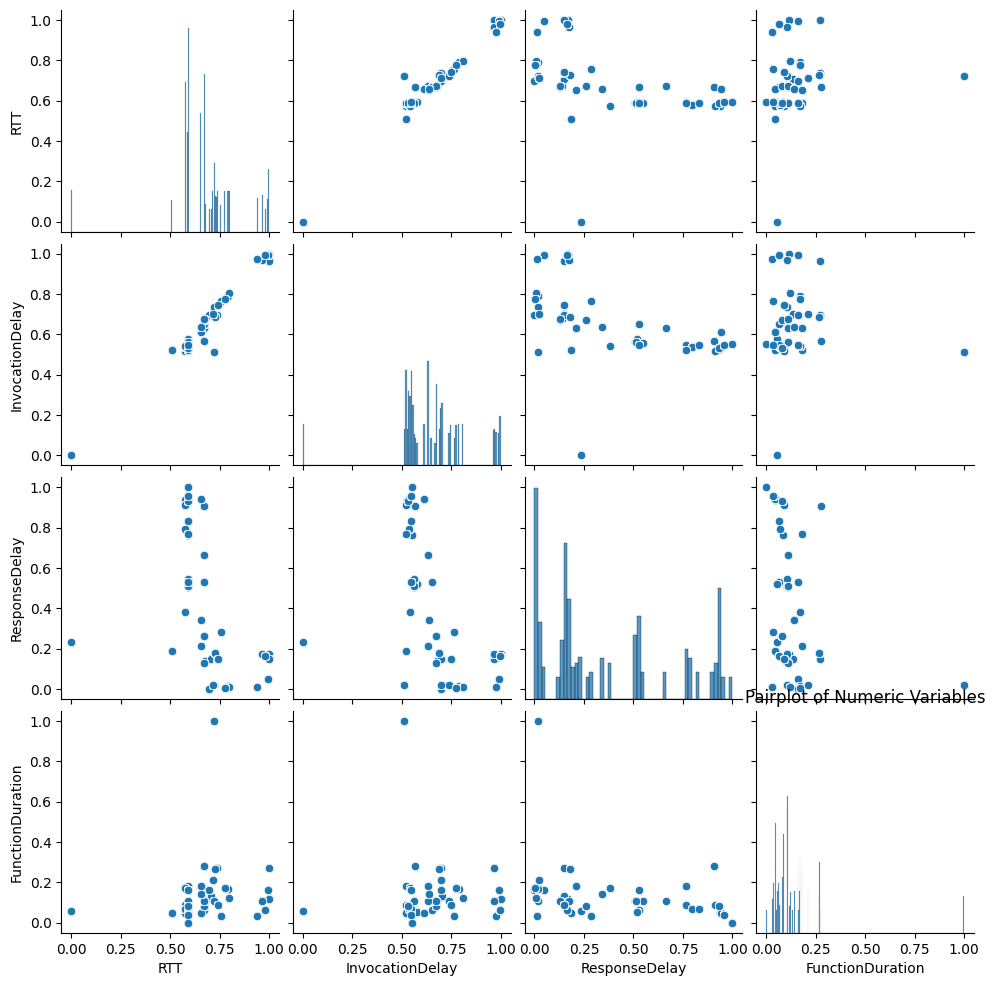

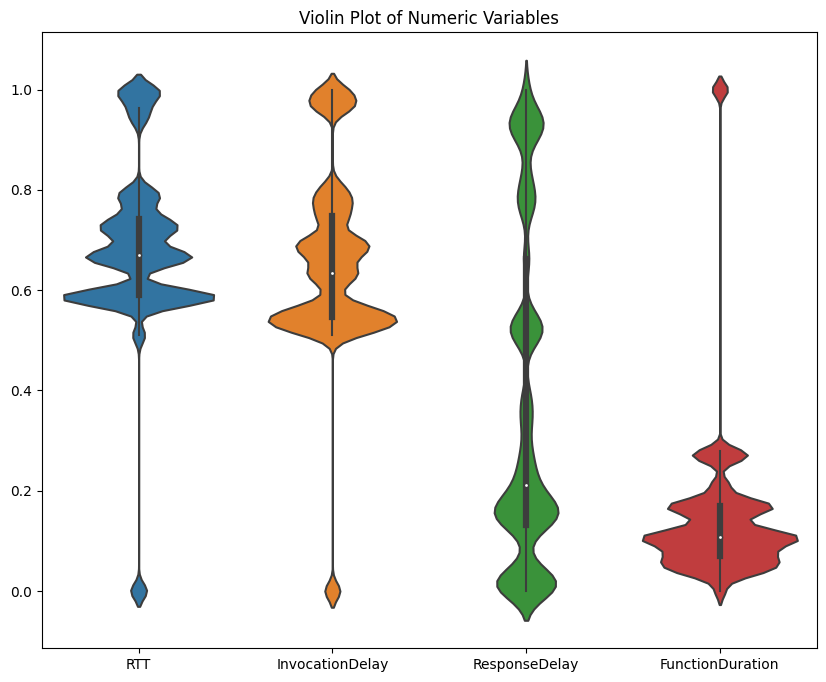

In [25]:
import seaborn as sns

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 1. Histograms
df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']].hist(figsize=(10, 8))
plt.suptitle('Distribution of Numeric Variables')
plt.show()

# 2. Box Plots
plt.figure(figsize=(10, 8))
sns.boxplot(data=df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Box Plot of Numeric Variables')
plt.show()

# 3. Bar Plot for 'vmcategory'
plt.figure(figsize=(8, 6))
df['vmcategory'].value_counts().plot(kind='bar')
plt.title('Frequency of VM Categories')
plt.xlabel('VM Category')
plt.ylabel('Frequency')
plt.show()

# 4. Scatter Plot (e.g., 'RTT' vs. 'ResponseDelay')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RTT', y='ResponseDelay', data=df)
plt.title('Scatter Plot of RTT vs. ResponseDelay')
plt.show()

# 6. Pairplot (selecting a subset of columns for demonstration)
sns.pairplot(df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Pairplot of Numeric Variables')
plt.show()

# 7. Violin Plots
plt.figure(figsize=(10, 8))
sns.violinplot(data=df[['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration']])
plt.title('Violin Plot of Numeric Variables')
plt.show()



In [26]:
import time
from sklearn.metrics import accuracy_score

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate model on testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Simulate attack detection and measure performance
start_time = time.time()
y_pred_val = model.predict(X_val)
total_delay = time.time() - start_time

y_pred_val_binary = (y_pred_val > 0.5).astype(int)
total_detected = y_pred_val_binary.sum()

# Calculate metrics
average_detection_delay = total_delay / total_detected if total_detected > 0 else 0
average_detection_accuracy = accuracy_score(y_val, y_pred_val_binary) * 100

print("Average Detection Delay (seconds):", average_detection_delay)
print("Average Detection Accuracy (%):", average_detection_accuracy)


1170/1170 [==============================] - 5s 4ms/step - loss: 5.6346e-09 - accuracy: 1.0000
Validation Loss: 5.6345594856566095e-09
Validation Accuracy: 1.0
1170/1170 [==============================] - 5s 4ms/step - loss: 5.6137e-09 - accuracy: 1.0000
Test Loss: 5.613685960526027e-09
Test Accuracy: 1.0
1170/1170 [==============================] - 5s 4ms/step
Average Detection Delay (seconds): 0.00020546440541828237
Average Detection Accuracy (%): 100.0
